In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import random
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("./adjusted library")  # in order to import the adjusted "ecg_plot" library
import ecg_plot_v2
# ecg_plot.__file__

## Convert dataset to image dataset

### Load signal and save them in a .npy file (run it only one time)

only run this block for first time, for next times do not run the below block

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


path = 'D:/Education/4_ECG digitalization with deep learning/Signal Dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
np.save(f'all_signals_{sampling_rate}Hz.npy', X)

### load .npy file containing signals

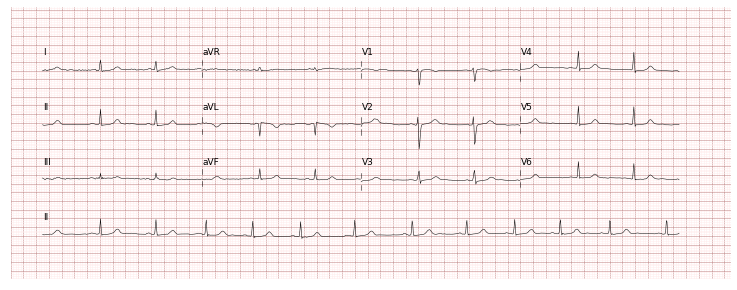

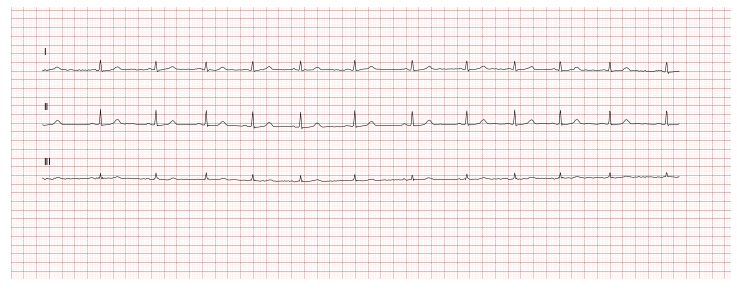

In [6]:
sampling_rate = 100
X = np.load(f'all_signals_{sampling_rate}Hz.npy')
lead_index = ['I', 'II', 'III', 'aVL', 'aVR', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']  # order of the leads in the dataset
lead_display = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] # order of the lead that I want to be shown


ecg_plot_v2.plot(ecg=X[13, :250, :].T, full_ecg=X[13, :, 1].T, full_ecg_name="II", sample_rate=100, columns=4, lead_index=lead_index, title='', lead_order=[0, 1, 2, 4, 3, 5, 6, 7, 8, 9, 10, 11],
              show_lead_name=True, show_grid=True, show_separate_line=True, row_height=6.3, style=None)

ecg_plot_v2.plot(ecg=X[13, :, :3].T, full_ecg=X[13, :, 1].T, full_ecg_name=None, sample_rate=100, columns=1, lead_index=lead_index, title='', lead_order=[0, 1, 2],
              show_lead_name=True, show_grid=True, show_separate_line=True, row_height=6.3, style=None)

ecg_plot_v2.show()

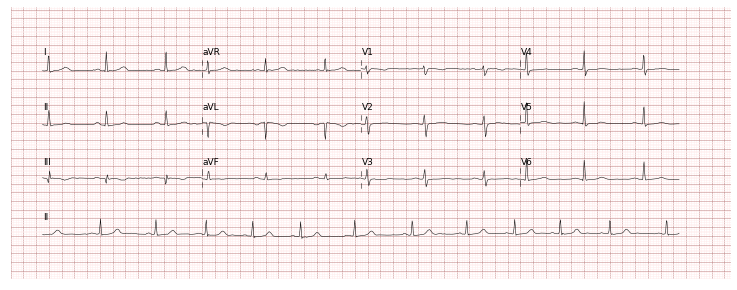

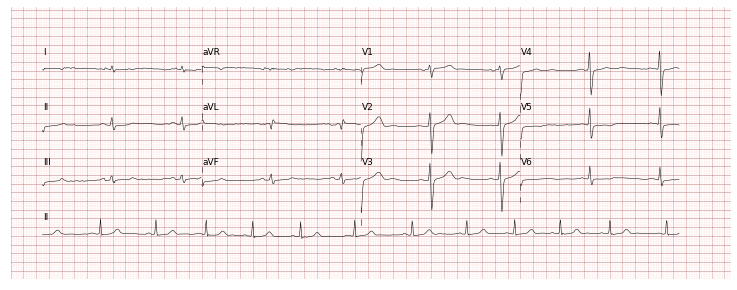

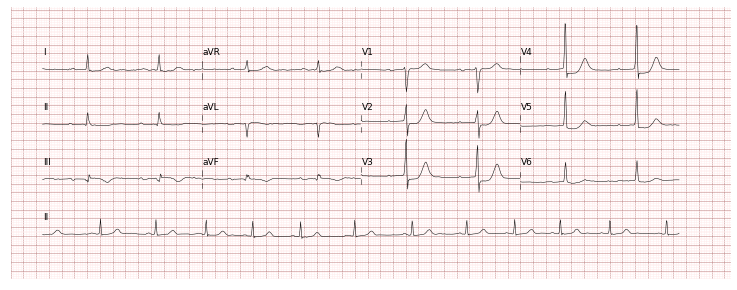

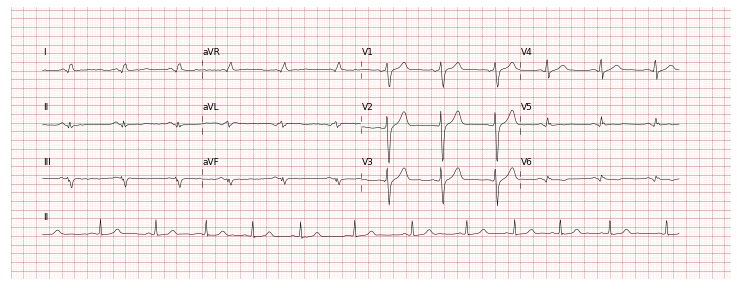

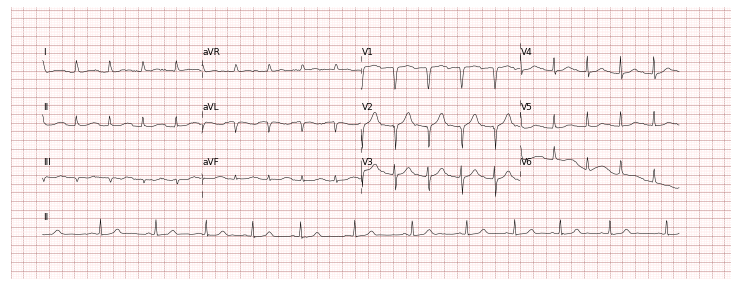

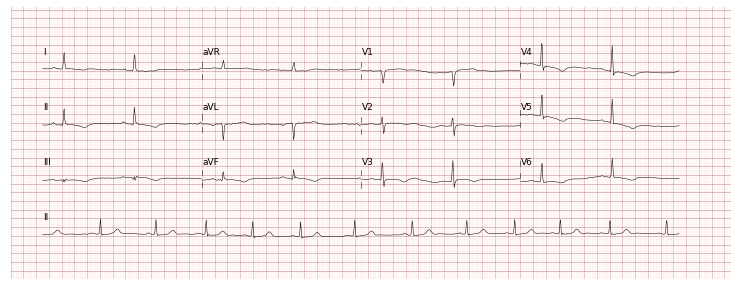

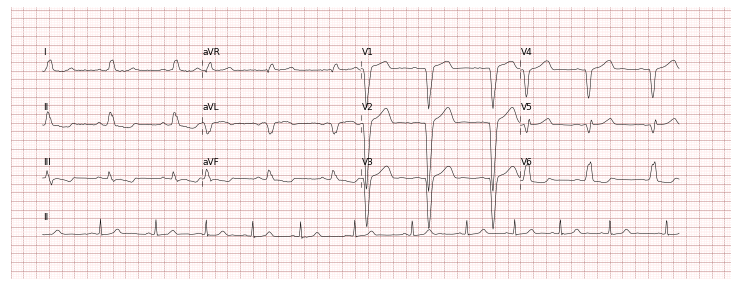

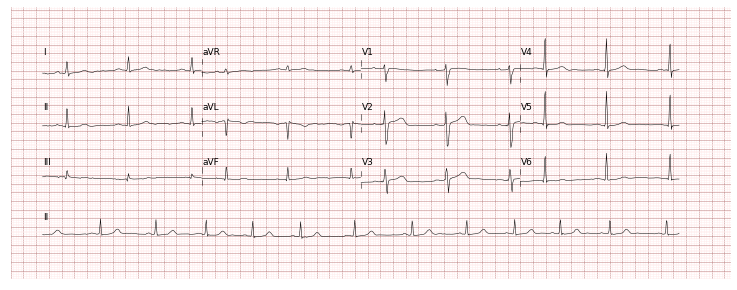

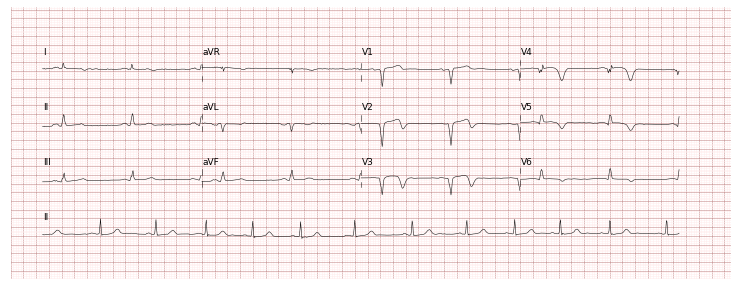

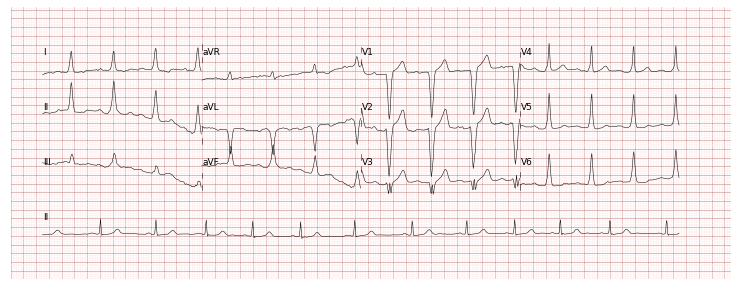

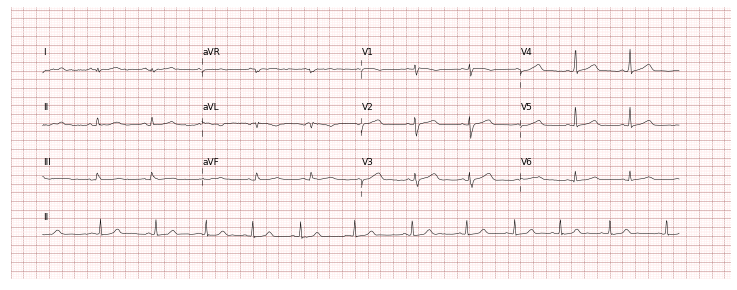

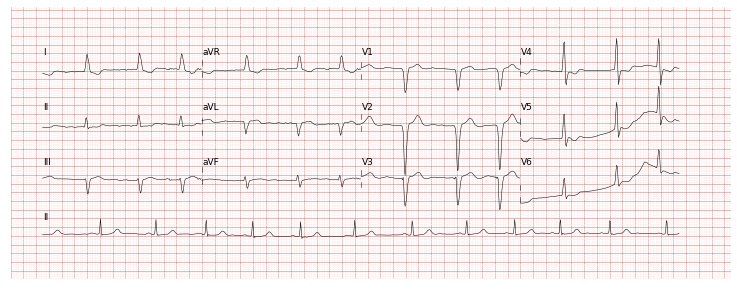

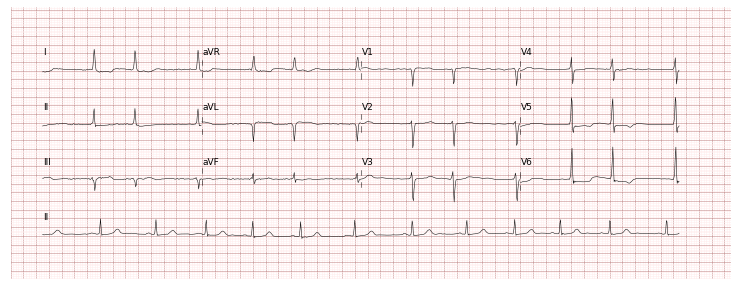

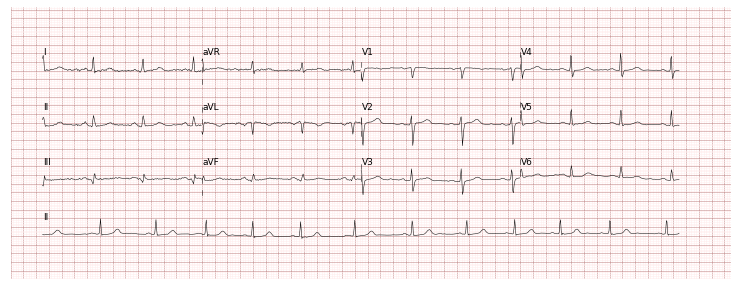

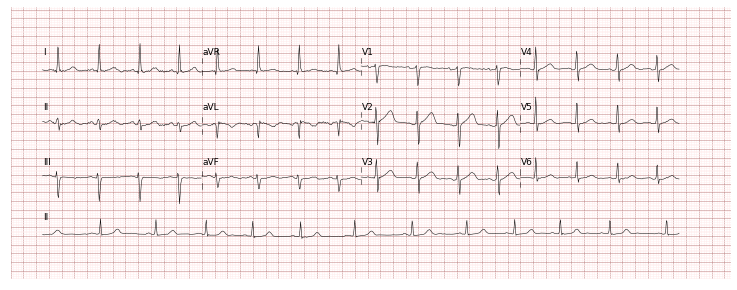

In [4]:
# plot some random images from the dataset
for i in random.sample(range(1, 21799), 15):
    ecg_plot_v2.plot(ecg=X[i, :250, :].T, full_ecg=X[13, :, 1].T, full_ecg_name='II', sample_rate=100, columns=4, lead_index=lead_index, title='', lead_order=[0, 1, 2, 4, 3, 5, 6, 7, 8, 9, 10, 11],
              show_lead_name=True, show_grid=True, show_separate_line=True, row_height=6.3, style=None)
    
    # ecg_plot_v2.plot(X[i, :250, :].T, sample_rate=100, columns=4, lead_index=lead_index, title='', lead_order=[0, 1, 2, 4, 3, 5, 6, 7, 8, 9, 10, 11],
    #             show_lead_name=True, show_grid=True, show_separate_line=True, row_height=6.3, style=None)


    ecg_plot_v2.show()
    plt.close()

### save image datset in drive

In [7]:
# TODO: image scale should be corrected(masoud will do it)
# TODO: add label for object detection task (i.e., bounding box, etc) (reza will do it)

lead_config = {'3by1': {'n_column':1, 'length': 1000, 'lead_order': list(range(3)), 'full_ecg_name': None}, 
               '3by4': {'n_column':4, 'length': 250, 'lead_order': list(range(12)), 'full_ecg_name': 'II'},
               '12by1':  {'n_column':1, 'length': 1000, 'lead_order': list(range(12)), 'full_ecg_name': None}, 
               '6by2': {'n_column':2, 'length': 500, 'lead_order': list(range(12)), 'full_ecg_name': 'II'}, 
               }  # key determines lead format, value determines some variable passing to ecg_plot_vs.plot
cnt = 0
step = 2       # number of images with same lead format; if step == 500, first 500 signals will be printed as 3by1 lead format, the next 500 signals will be printed as 3by4 format
for lead_format, each_lead_config in lead_config.items():
    for i in range(cnt, cnt + step):    # using cnt and step, we will have first 500 (`step=500`) data in the first lead_format and the next 500 data will be in the second lead_format and so on 
        ecg_plot_v2.plot(ecg=X[i, :each_lead_config['length'], :].T, full_ecg=X[i, :, 1].T, 
                         full_ecg_name=each_lead_config['full_ecg_name'], sample_rate=100, 
                         columns=each_lead_config['n_column'], lead_index=lead_index, title='', 
                         lead_order=each_lead_config['lead_order'], show_lead_name=True, show_grid=True, 
                         show_separate_line=True, row_height=6.3, style=None)

        ecg_plot_v2.save_as_jpg(str(i)+'_'+lead_format, path='../../image_dataset_v3.0/', dpi=100)

    cnt += step

### add noise to image dataset

In [5]:
import cv2

def add_shadow(image, start_x, start_y, end_x, end_y, shadow_intensity=0.5):
    shadow = image.copy()

    # Create a mask for the shadow region
    mask = np.zeros_like(image)
    mask[start_y:end_y, start_x:end_x, :] = 1

    # Darken the shadow region
    shadow[start_y:end_y, start_x:end_x, :] *= (1 - shadow_intensity)

    # Add the shadow to the original image
    result = cv2.addWeighted(image, 1, shadow, shadow_intensity, 0)

    return result

shadow_start_x = 100
shadow_start_y = 100
shadow_end_x = 300
shadow_end_y = 400

# Add a shadow to the specified region
image_with_shadow = add_shadow(X[13, :250, :].T, shadow_start_x, shadow_start_y, shadow_end_x, shadow_end_y)

ModuleNotFoundError: No module named 'cv2'